In [1]:
import xarray as xr

In [2]:
import sys
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys/')

In [3]:
from project_analysis.jumping.Dec2020.analyze_jump import animated_gaze_plot

In [4]:
from utils.paths import find

In [5]:
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
import numpy as np

In [6]:
import os
from tqdm import tqdm

In [7]:
recording_name = '071620_PV-CHR11P1LT_016'

In [8]:
REye_ds = xr.open_dataset(find('*REYE.nc', os.path.join('/home/niell_lab/data/jumping/timebin_eyecams_2sec_091721/',recording_name))[0])
LEye_ds = xr.open_dataset(find('*LEYE.nc', os.path.join('/home/niell_lab/data/jumping/timebin_eyecams_2sec_091721/',recording_name))[0])
Top_ds = xr.open_dataset(find('*Top.nc', os.path.join('/home/niell_lab/data/jumping/timebin_eyecams_2sec_091721/',recording_name))[0])
SIDE_ds = xr.open_dataset(find('*016_side.nc', os.path.join('/home/niell_lab/data/jumping/timebin_eyecams_2sec_091721/',recording_name))[0])

In [9]:
Side_vid_path = find('*Side.avi', os.path.join('/home/niell_lab/data/jumping/timebin_eyecams_2sec_091721/',recording_name))[0]
LEye_vid_path = find('*LEYEdeinter.avi', os.path.join('/home/niell_lab/data/jumping/timebin_eyecams_2sec_091721/',recording_name))[0]
REye_vid_path = find('*REYEdeinter.avi', os.path.join('/home/niell_lab/data/jumping/timebin_eyecams_2sec_091721/',recording_name))[0]
Top_vid_path = find('*Top.avi', os.path.join('/home/niell_lab/data/jumping/timebin_eyecams_2sec_091721/',recording_name))[0]

In [10]:
config = {
    'lik_thresh': 0.99,
    'trial_head': '/home/niell_lab/Desktop/',
    'recording_name': recording_name
}

In [11]:
# organize data
REye = REye_ds.REYE_ellipse_params
LEye = LEye_ds.LEYE_ellipse_params
head_pitch = SIDE_ds.SIDE_theta

# zero-center theta and phi for each eye, and flip sign of phi
RTheta = np.rad2deg(REye.sel(ellipse_params='theta')) - np.rad2deg(np.nanmedian(REye.sel(ellipse_params='theta')))
RPhi = (np.rad2deg(REye.sel(ellipse_params='phi')) - np.rad2deg(np.nanmedian(REye.sel(ellipse_params='phi'))))
LTheta = np.rad2deg(LEye.sel(ellipse_params='theta')) -  np.rad2deg(np.nanmedian(LEye.sel(ellipse_params='theta')))
LPhi = (np.rad2deg(LEye.sel(ellipse_params='phi')) - np.rad2deg(np.nanmedian(LEye.sel(ellipse_params='phi'))))

# zero-center head pitch, and get rid of wrap-around effect (mod 360)
pitch = np.rad2deg(head_pitch)
pitch = ((pitch+360) % 360)
pitch = pitch - np.nanmean(pitch) # have to mean center as last step so that it's comparable on plots--is it okay for this to be different in video plotting? I would think so

# interpolate over eye paramters to match head pitch
RTheta_interp = RTheta.interp_like(pitch, method='linear')
RPhi_interp = RPhi.interp_like(pitch, method='linear')
LTheta_interp = LTheta.interp_like(pitch, method='linear')
LPhi_interp = LPhi.interp_like(pitch, method='linear')

In [12]:
# eye divergence (theta)
div = (RTheta_interp - LTheta_interp)
# gaze (mean theta of eyes)
gaze_th = (RTheta_interp + LTheta_interp) * 0.5
# gaze (mean phi of eyes)
gaze_phi = (RPhi_interp + LPhi_interp) * 0.5

# correct lengths when off
pitch_len = len(pitch.values); gaze_th_len = len(gaze_th.values); div_len = len(div.values); gaze_phi_len = len(gaze_phi.values)
min_len = np.min([pitch_len, gaze_th_len, div_len, gaze_phi_len])
max_len = np.max([pitch_len, gaze_th_len, div_len, gaze_phi_len])
if max_len != min_len:
    pitch = pitch.isel(frame=range(0,min_len))
    gaze_th = gaze_th.isel(frame=range(0,min_len))
    div = div.isel(frame=range(0,min_len))
    gaze_phi = gaze_phi.isel(frame=range(0,min_len))

100%|█████████████████████████████████████████| 470/470 [00:37<00:00, 12.63it/s]


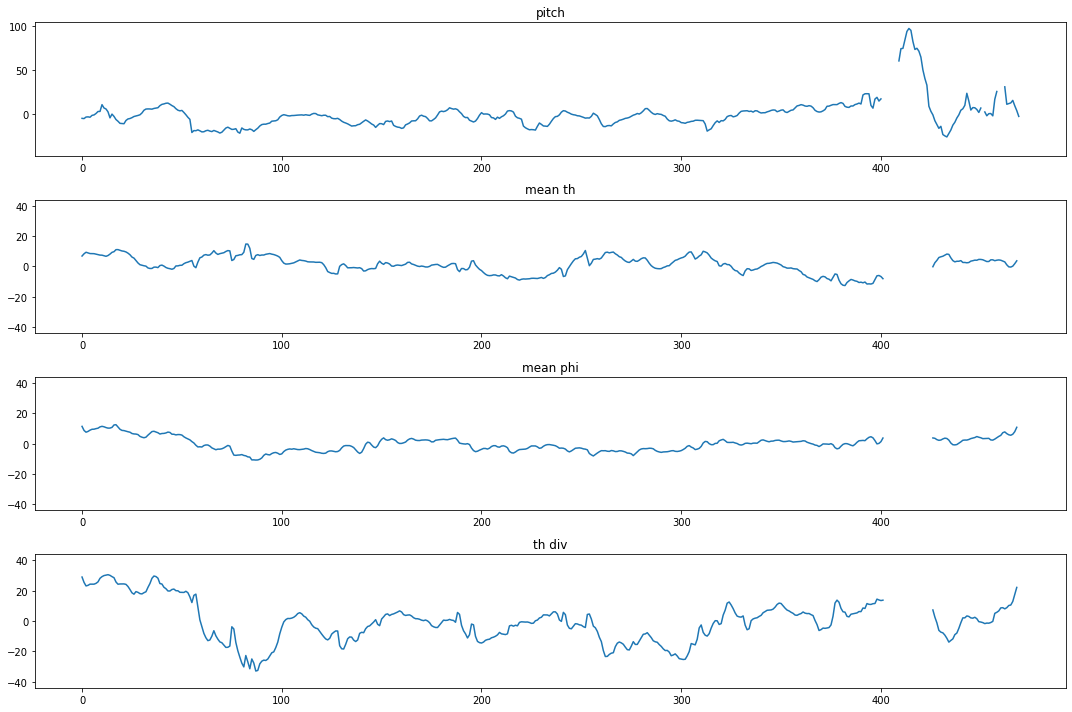

In [13]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,10))
ax1.plot(pitch, '-', color='tab:blue'); ax1.set_title('pitch')
ax2.plot(gaze_th, '-', color='tab:blue'); ax2.set_title('mean th')
ax3.plot(gaze_phi, '-', color='tab:blue'); ax3.set_title('mean phi')
ax4.plot(div, '-', color='tab:blue'); ax4.set_title('th div')
plt.tight_layout()

ani_save_path = os.path.join(config['trial_head'], (config['recording_name'] + '_params_animation.avi'))
writer = FFMpegWriter(fps=60, bitrate=-1)
with writer.saving(fig, ani_save_path, 150):
    for t in tqdm(range(0,len(pitch))):
        ln1 = ax1.vlines(t,-40,40)
        ln2 = ax2.vlines(t,-40,40)
        ln3 = ax3.vlines(t,-40,40)
        ln4 = ax4.vlines(t,-40,40)
        writer.grab_frame()
        ln1.remove(); ln2.remove(); ln3.remove(); ln4.remove()

In [14]:
animated_gaze_plot(REye_ds, LEye_ds, Top_ds, SIDE_ds, Side_vid_path, LEye_vid_path, REye_vid_path, Top_vid_path, config)

 85%|██████████████████████████████████▉      | 401/470 [00:40<00:06, 10.83it/s]/home/niell_lab/Documents/github/FreelyMovingEphys/project_analysis/jumping/Dec2020/analyze_jump.py:477: RuntimeWarning: invalid value encountered in double_scalars
  pitch = ((pitch+360) % 360)
100%|████████████████████████████████████████▉| 469/470 [00:46<00:00, 10.09it/s]
